# Execução das NFTs Criadas e com mais de 1500 transações a partir de Abril 2023 nos modelos do Comite de Classificação de AM

## Packages and libraries

In [1]:
pip install google-cloud-bigquery db-dtypes pandas tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importar pacotes
import os
import requests
import numpy as np
import glob
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.cluster import DBSCAN

from tensorflow import keras
from tensorflow.keras import layers, models

## Funções

In [3]:
def lista_comum_df():
  # Lista vazia para armazenar os dataframes
  df_comum_list = []

  # Localizar todos os arquivos CSV no diretório atual
  for filename in glob.glob("Z:/Python/Data/Coleta_NFT/Abril/Copia_Arq/*.CSV"): 
      # Ler o arquivo CSV em um dataframe
      df = pd.read_csv(filename)
      # Adicionar o dataframe à lista
      df_comum_list.append(df)


  return df_comum_list

In [4]:
def lista_df():
  # Lista vazia para armazenar os dataframes
  df_list = []

  # Localizar todos os arquivos CSV no diretório atual
  for filename in glob.glob("Z:/Python/Data/Blue_Chips/*.csv"):
      # Ler o arquivo CSV em um dataframe
      df = pd.read_csv(filename)
      # Adicionar o dataframe à lista
      df_list.append(df)

  return df_list

In [5]:
def process_dataframe(df):
    # Convertendo a coluna 'BLOCK_TIMESTAMP' e 'BLOCK_TIMESTAMP_BLUE' para o tipo datetime
    df['BLOCK_TIMESTAMP'] = pd.to_datetime(df['BLOCK_TIMESTAMP'])

    # Criando uma nova coluna com a data (sem o horário) dos blocos
    df['BLOCK_DATE'] = df['BLOCK_TIMESTAMP'].dt.date

    # Convertendo a coluna 'BLOCK_DATE' para o tipo datetime
    df['BLOCK_DATE'] = pd.to_datetime(df['BLOCK_DATE'])

In [6]:
# Função para normalizar uma lista de DataFrames
def normalize_dataframes(dataframe_list):
    # Inicialize o MinMaxScaler
    scaler = MinMaxScaler()

    for idx, ts in enumerate(dataframe_list):
        # Selecione apenas as colunas numéricas para normalização
        columns_to_normalize = [
            'QTDE_TRANSACOES_DIA',
            'MEDIA_GAS_DIA',
            'MEDIA_GAS_LIMIT_DIA',
            'QTDE_COMPRADORES_UNICOS_DIA',
            'QTDE_VENDEDORES_UNICOS_DIA',
            'NOVOS_TITULARES'
        ]

        # Aplique o Min-Max Scaling às colunas selecionadas
        dataframe_list[idx][columns_to_normalize] = scaler.fit_transform(ts[columns_to_normalize])



In [7]:
# Função para imprimir informações e os 5 primeiros registros de uma lista de DataFrames
def print_info_and_head(dataframe_list):
    for i, df in enumerate(dataframe_list):
        print(f"\nDataFrame {i+1}:")
        print("Informações após a normalização:")
        print(df.info())
        print("5 primeiros registros após a normalização:")
        print(df.head())

In [8]:
# Função para calcular e retornar a média de precisão, recall e F1-score
def calculate_metrics(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

In [9]:
# Função para calcular e imprimir a matriz de confusão
def print_confusion_matrix(true_labels, predictions):
    confusion = confusion_matrix(true_labels, predictions)
    print("Matriz de Confusão:")
    print(confusion)

In [10]:
def encontrar_tp(confusion_matrix_val):
    """
    Verifique se um Verdadeiro Positivo (TP) ocorreu em uma única matriz de confusão. Posição no array da matriz para TP é [0,0], ou seja, primeira linha e primeira coluna

    Args:
        confusion_matrix_val (array): Matriz de confusão para um único conjunto de teste.

    Returns:
        bool: True se um TP for encontrado no conjunto de teste, False caso contrário.
    """
    tp_found = confusion_matrix_val[0, 0] > 0
    return tp_found

## Execuções 

In [11]:
list_df_blue = []
list_df_blue = lista_df()
len(list_df_blue)

20

In [12]:
list_df_comum = []
list_df_comum = lista_comum_df()
len(list_df_comum)

55

## Conjunto de Dados - Data Sets (NFT's Blue Chip's e NFT's Comuns)

Arquivos CSV criados a partir da extração de dados no Google BigQuery contém as seguintes informações:

* BLOCK_TIMESTAMP: timestamp do bloco em que a transferência foi registrada.
* FROM_ADDRESS: endereço da carteira que enviou os tokens.
* TO_ADDRESS: endereço da carteira que recebeu os tokens.
* VALUE: valor da transferência em wei, a menor unidade de ether (a criptomoeda da Ethereum).
* TRANSACTION_HASH: hash da transação na blockchain Ethereum.
* NONCE: número de sequência da transação na carteira que a criou.
* FROM_ADDRESS_BLOCKCHAIN: endereço da carteira que enviou a transação na blockchain Ethereum.
* TO_ADDRESS_BLOCKCHAIN: endereço da carteira que recebeu a transação na blockchain Ethereum.
* GAS: quantidade de gas (unidade de custo de processamento na Ethereum) usada pela transação.
* RECEIPT_GAS_USED: quantidade de gas usada para executar a transferência de tokens.

In [13]:
# Loop para iterar sobre as list_df_blue, list_df_comum
for idx, df_group in enumerate([list_df_blue, list_df_comum]):
    if idx == 0:
        group_label = "Blue Chip"
    else:
        group_label = "Comum"

    for i, df_aux in enumerate(df_group):
        print(f"\nData Frame {group_label} {i+1}")
        print("Informações:")
        df_aux.info()
        print("\n5 primeiros registros:")
        print(df_aux.head())



Data Frame Blue Chip 1
Informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98206 entries, 0 to 98205
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             98206 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     98206 non-null  object
 2   BLOCK_TIMESTAMP          98206 non-null  object
 3   FROM_ADDRESS             98206 non-null  object
 4   TO_ADDRESS               98206 non-null  object
 5   VALUE                    98206 non-null  int64 
 6   TRANSACTION_HASH         98206 non-null  object
 7   NONCE                    98206 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  98206 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    98206 non-null  object
 10  GAS                      98206 non-null  int64 
 11  RECEIPT_GAS_USED         98206 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.0+ MB

5 primeiros registros:
                                 ADDRE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93723 entries, 0 to 93722
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             93723 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     93723 non-null  object
 2   BLOCK_TIMESTAMP          93723 non-null  object
 3   FROM_ADDRESS             93723 non-null  object
 4   TO_ADDRESS               93723 non-null  object
 5   VALUE                    93723 non-null  int64 
 6   TRANSACTION_HASH         93723 non-null  object
 7   NONCE                    93723 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  93723 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    93723 non-null  object
 10  GAS                      93723 non-null  int64 
 11  RECEIPT_GAS_USED         93723 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 8.6+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TIMESTAMP_BLUE  \
0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59662 entries, 0 to 59661
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             59662 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     59662 non-null  object
 2   BLOCK_TIMESTAMP          59662 non-null  object
 3   FROM_ADDRESS             59662 non-null  object
 4   TO_ADDRESS               59662 non-null  object
 5   VALUE                    59662 non-null  int64 
 6   TRANSACTION_HASH         59662 non-null  object
 7   NONCE                    59662 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  59662 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    59662 non-null  object
 10  GAS                      59662 non-null  int64 
 11  RECEIPT_GAS_USED         59662 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 5.5+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TIMESTAMP_BLUE  \
0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210339 entries, 0 to 210338
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ADDRESS_BLUE             210339 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     210339 non-null  object
 2   BLOCK_TIMESTAMP          210339 non-null  object
 3   FROM_ADDRESS             210339 non-null  object
 4   TO_ADDRESS               210339 non-null  object
 5   VALUE                    210339 non-null  int64 
 6   TRANSACTION_HASH         210339 non-null  object
 7   NONCE                    210339 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  210339 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    210339 non-null  object
 10  GAS                      210339 non-null  int64 
 11  RECEIPT_GAS_USED         210339 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 19.3+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TI

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98937 entries, 0 to 98936
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             98937 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     98937 non-null  object
 2   BLOCK_TIMESTAMP          98937 non-null  object
 3   FROM_ADDRESS             98937 non-null  object
 4   TO_ADDRESS               98937 non-null  object
 5   VALUE                    98937 non-null  int64 
 6   TRANSACTION_HASH         98937 non-null  object
 7   NONCE                    98937 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  98937 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    98937 non-null  object
 10  GAS                      98937 non-null  int64 
 11  RECEIPT_GAS_USED         98937 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.1+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TIMESTAMP_BLUE  \
0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119029 entries, 0 to 119028
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ADDRESS_BLUE             119029 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     119029 non-null  object
 2   BLOCK_TIMESTAMP          119029 non-null  object
 3   FROM_ADDRESS             119029 non-null  object
 4   TO_ADDRESS               119029 non-null  object
 5   VALUE                    119029 non-null  int64 
 6   TRANSACTION_HASH         119029 non-null  object
 7   NONCE                    119029 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  119029 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    119029 non-null  object
 10  GAS                      119029 non-null  int64 
 11  RECEIPT_GAS_USED         119029 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 10.9+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TI

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   TOKEN_ADDRESS            81 non-null     object
 1   BLOCK_TIMESTAMP          81 non-null     object
 2   FROM_ADDRESS             81 non-null     object
 3   TO_ADDRESS               81 non-null     object
 4   VALUE                    81 non-null     int64 
 5   TRANSACTION_HASH         81 non-null     object
 6   NONCE                    81 non-null     int64 
 7   FROM_ADDRESS_BLOCKCHAIN  81 non-null     object
 8   TO_ADDRESS_BLOCKCHAIN    81 non-null     object
 9   GAS                      81 non-null     int64 
 10  RECEIPT_GAS_USED         81 non-null     int64 
dtypes: int64(4), object(7)
memory usage: 7.1+ KB

5 primeiros registros:
                                TOKEN_ADDRESS            BLOCK_TIMESTAMP  \
0  0x696418f16804228d86266e12db5c5178e81a37c0  2023-04-01 

In [14]:
# Processando a lista de DataFrames list_df_blue
df_list_blue = []
for df_blue in list_df_blue:
    process_dataframe(df_blue)
    df_list_blue.append(df_blue)

# Processando a lista de DataFrames list_df_comum
df_list_comum = []
for df_comum in list_df_comum:
    process_dataframe(df_comum)
    df_list_comum.append(df_comum)


## Execução - Pré-Processamento para agrupamento e geração das Séries temporais multivariadas

In [15]:
list_grouped_df_blue = []
list_grouped_df_comum = []

# Loop para agrupar os DataFrames e criar as listas list_grouped_df_blue e list_grouped_df_comum
for dataframe_list, grouped_list in zip([df_list_blue, df_list_comum], [list_grouped_df_blue, list_grouped_df_comum]):
    for df in dataframe_list:
        grouped_df = df.groupby('BLOCK_DATE')
        grouped_list.append(grouped_df)

# Loop para imprimir os tamanhos dos grupos para ambos os DataFrames agrupados
for label, grouped_list in [("Blue Chip", list_grouped_df_blue), ("Comum", list_grouped_df_comum)]:
    print(f"\n{label} DataFrames:")
    
    for i, grouped_df in enumerate(grouped_list):
        print(f"\ngrouped_df_{label} {i+1}")
        
        # Use a função size() para obter o tamanho de cada grupo
        group_sizes = grouped_df.size()
        
        # Imprima os tamanhos dos grupos
        print(group_sizes)



Blue Chip DataFrames:

grouped_df_Blue Chip 1
BLOCK_DATE
2022-01-06    8231
2022-01-07    2905
2022-01-08    1250
2022-01-09     618
2022-01-10     315
              ... 
2023-03-10     102
2023-03-11      36
2023-03-12     150
2023-03-13      64
2023-03-14       5
Length: 433, dtype: int64

grouped_df_Blue Chip 2
BLOCK_DATE
2022-04-29     15000
2022-04-30        81
2022-05-01    131388
2022-05-02     16965
2022-05-03      6447
               ...  
2023-03-10      1182
2023-03-11      1057
2023-03-12       723
2023-03-13       857
2023-03-14        48
Length: 320, dtype: int64

grouped_df_Blue Chip 3
BLOCK_DATE
2021-07-22    9654
2021-07-23     515
2021-07-24     232
2021-07-25     256
2021-07-26     166
              ... 
2023-03-10     206
2023-03-11     152
2023-03-12     101
2023-03-13     174
2023-03-14      22
Length: 601, dtype: int64

grouped_df_Blue Chip 4
BLOCK_DATE
2022-10-31    3734
2022-11-01     165
2022-11-02      94
2022-11-03     110
2022-11-04      20
              .

BLOCK_DATE
2023-04-01    168207
2023-04-02    171523
2023-04-03    197518
2023-04-04    190486
2023-04-05    177336
2023-04-06    168669
2023-04-07    162635
2023-04-08    156727
2023-04-09    144948
2023-04-10    167060
2023-04-11    166417
2023-04-12    172837
2023-04-13    162183
2023-04-14    197063
2023-04-15    168419
2023-04-16    181654
2023-04-17    284442
2023-04-18    345231
2023-04-19    396603
2023-04-20    367968
2023-04-21    280787
2023-04-22    263078
2023-04-23    301054
2023-04-24    295272
2023-04-25    267800
2023-04-26    264764
2023-04-27    237736
2023-04-28    275657
2023-04-29    266547
2023-04-30    358263
dtype: int64

grouped_df_Comum 46
BLOCK_DATE
2023-04-03     4
2023-04-09    13
dtype: int64

grouped_df_Comum 47
BLOCK_DATE
2023-04-01    29
2023-04-02    16
2023-04-03     7
2023-04-04     7
2023-04-05     8
2023-04-06     4
2023-04-07     8
2023-04-08     2
2023-04-09    39
2023-04-10     8
2023-04-11    16
2023-04-12     9
2023-04-13     6
2023-04-14    

In [16]:
ts_nft_comum = []  # Lista para armazenar os DataFrames criados a partir de list_grouped_df_comum
ts_nft_blue = []   # Lista para armazenar os DataFrames criados a partir de list_grouped_df_blue

# Loop para iterar sobre list_grouped_df_comum e list_grouped_df_blue
for label, grouped_list, ts_nft_list in [("Comum", list_grouped_df_comum, ts_nft_comum), ("Blue Chip", list_grouped_df_blue, ts_nft_blue)]:
    print(f"\n{label} DataFrames:")
    
    for i, ts in enumerate(grouped_list):
        print(f"\ngrouped_df_{label} {i+1}")
        
        # Criar um novo DataFrame vazio para cada grupo
        df = pd.DataFrame()
        
        # Adicionar a coluna 'BLOCK_DATE' ao DataFrame
        df['BLOCK_DATE'] = ts['BLOCK_DATE'].mean()
        
        # Número de transações diárias
        df['QTDE_TRANSACOES_DIA'] = ts['BLOCK_DATE'].count()
        
        # Média de GAS diário
        df['MEDIA_GAS_DIA'] = ts['GAS'].mean()
        
        # Média de GAS_LIMIT diário
        df['MEDIA_GAS_LIMIT_DIA'] = ts['RECEIPT_GAS_USED'].mean()
        
        # Quantidade de compradores únicos diários
        df['QTDE_COMPRADORES_UNICOS_DIA'] = ts['FROM_ADDRESS'].nunique()
        
        # Quantidade de vendedores únicos diários
        df['QTDE_VENDEDORES_UNICOS_DIA'] = ts['TO_ADDRESS'].nunique()
        
        # Cálculo de NOVOS_TITULARES
        df['NOVOS_TITULARES'] = (ts['FROM_ADDRESS'].nunique() + ts['TO_ADDRESS'].nunique()) / (ts['FROM_ADDRESS'].count() + ts['TO_ADDRESS'].count()) 
        
        # Transforma a coluna 'BLOCK_DATE' em índice temporal
        df.set_index('BLOCK_DATE', inplace=True)
        
        # Adicionar o DataFrame criado à lista correspondente
        ts_nft_list.append(df)



Comum DataFrames:

grouped_df_Comum 1

grouped_df_Comum 2

grouped_df_Comum 3

grouped_df_Comum 4

grouped_df_Comum 5

grouped_df_Comum 6

grouped_df_Comum 7

grouped_df_Comum 8

grouped_df_Comum 9

grouped_df_Comum 10

grouped_df_Comum 11

grouped_df_Comum 12

grouped_df_Comum 13

grouped_df_Comum 14

grouped_df_Comum 15

grouped_df_Comum 16

grouped_df_Comum 17

grouped_df_Comum 18

grouped_df_Comum 19

grouped_df_Comum 20

grouped_df_Comum 21

grouped_df_Comum 22

grouped_df_Comum 23

grouped_df_Comum 24

grouped_df_Comum 25

grouped_df_Comum 26

grouped_df_Comum 27

grouped_df_Comum 28

grouped_df_Comum 29

grouped_df_Comum 30

grouped_df_Comum 31

grouped_df_Comum 32

grouped_df_Comum 33

grouped_df_Comum 34

grouped_df_Comum 35

grouped_df_Comum 36

grouped_df_Comum 37

grouped_df_Comum 38

grouped_df_Comum 39

grouped_df_Comum 40

grouped_df_Comum 41

grouped_df_Comum 42

grouped_df_Comum 43

grouped_df_Comum 44

grouped_df_Comum 45

grouped_df_Comum 46

grouped_df_Comum 47

gr

In [17]:
# Imprimir informações e os 5 primeiros registros de ts_nft_blue após a normalização
print("Informações e 5 primeiros registros de ts_nft_blue após a normalização:")
print_info_and_head(ts_nft_blue)

print("\n=======================================================================================\n")


# Imprimir informações e os 5 primeiros registros de ts_nft_comum após a normalização
print("Informações e 5 primeiros registros de ts_nft_comum após a normalização:")
print_info_and_head(ts_nft_comum)

Informações e 5 primeiros registros de ts_nft_blue após a normalização:

DataFrame 1:
Informações após a normalização:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 2022-01-06 00:00:00 to 2023-03-14 00:00:00
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QTDE_TRANSACOES_DIA          433 non-null    int64  
 1   MEDIA_GAS_DIA                433 non-null    float64
 2   MEDIA_GAS_LIMIT_DIA          433 non-null    float64
 3   QTDE_COMPRADORES_UNICOS_DIA  433 non-null    int64  
 4   QTDE_VENDEDORES_UNICOS_DIA   433 non-null    int64  
 5   NOVOS_TITULARES              433 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 23.7 KB
None
5 primeiros registros após a normalização:
            QTDE_TRANSACOES_DIA  MEDIA_GAS_DIA  MEDIA_GAS_LIMIT_DIA  \
BLOCK_DATE                                                            
2022-01-06                 8231  33

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 681 entries, 2021-05-03 00:00:00 to 2023-03-14 00:00:00
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QTDE_TRANSACOES_DIA          681 non-null    int64  
 1   MEDIA_GAS_DIA                681 non-null    float64
 2   MEDIA_GAS_LIMIT_DIA          681 non-null    float64
 3   QTDE_COMPRADORES_UNICOS_DIA  681 non-null    int64  
 4   QTDE_VENDEDORES_UNICOS_DIA   681 non-null    int64  
 5   NOVOS_TITULARES              681 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 37.2 KB
None
5 primeiros registros após a normalização:
            QTDE_TRANSACOES_DIA  MEDIA_GAS_DIA  MEDIA_GAS_LIMIT_DIA  \
BLOCK_DATE                                                            
2021-05-03                14554   3.937872e+05        165456.006802   
2021-05-04                 3854   1.032963e+06        637397.366373   
2021-05-05  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-04-01 to 2023-04-30
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QTDE_TRANSACOES_DIA          30 non-null     int64  
 1   MEDIA_GAS_DIA                30 non-null     float64
 2   MEDIA_GAS_LIMIT_DIA          30 non-null     float64
 3   QTDE_COMPRADORES_UNICOS_DIA  30 non-null     int64  
 4   QTDE_VENDEDORES_UNICOS_DIA   30 non-null     int64  
 5   NOVOS_TITULARES              30 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.6 KB
None
5 primeiros registros após a normalização:
            QTDE_TRANSACOES_DIA  MEDIA_GAS_DIA  MEDIA_GAS_LIMIT_DIA  \
BLOCK_DATE                                                            
2023-04-01                   29  321198.655172        104159.172414   
2023-04-02                   16  229434.687500        105168.125000   
2023-04-03                    7 

In [18]:
# Verifique os 5 primeiros registros de ts_nft_comum
print("5 primeiros registros de ts_nft_comum:")
for i, df in enumerate(ts_nft_comum):
    print(f"\nDataFrame {i+1} (ts_nft_comum):")
    print(df.head(5))

# Verifique os 5 primeiros registros de ts_nft_blue
print("\n5 primeiros registros de ts_nft_blue:")
for i, df in enumerate(ts_nft_blue):
    print(f"\nDataFrame {i+1} (ts_nft_blue):")
    print(df.head(5))


5 primeiros registros de ts_nft_comum:

DataFrame 1 (ts_nft_comum):
            QTDE_TRANSACOES_DIA  MEDIA_GAS_DIA  MEDIA_GAS_LIMIT_DIA  \
BLOCK_DATE                                                            
2023-04-01                    4  526956.500000              44672.5   
2023-04-02                    1   44508.000000              35662.0   
2023-04-03                   12  183333.333333              45133.0   
2023-04-08                    5   49578.400000              44111.6   
2023-04-09                    1   44521.000000              35674.0   

            QTDE_COMPRADORES_UNICOS_DIA  QTDE_VENDEDORES_UNICOS_DIA  \
BLOCK_DATE                                                            
2023-04-01                            4                           4   
2023-04-02                            1                           1   
2023-04-03                            6                           2   
2023-04-08                            4                           5   
2023-04-

## Execução - Normalização das Séries Temporais Multivariadas

In [19]:
# Normalizar ts_nft_comum
normalize_dataframes(ts_nft_comum)

# Normalizar ts_nft_blue
normalize_dataframes(ts_nft_blue)


## Divisão do dados do Dataframe Blue Chips normalizados 

Divisão do DataFrame (normalized_dataset) em conjuntos de treinamento, validação e teste usando a função train_test_split do scikit-learn.

* train_test_split(normalized_dataset, test_size=0.4, random_state=42): Divisão do DataFrame **normalized_dataset** em dois conjuntos, o conjunto de **treinamento (train_data)** e o conjunto **temporário (temp_data)**. O hiperparâmetro test_size=0.4 define que 40% dos dados serão usados para o conjunto de teste e, consequentemente, 60% dos dados restantes serão usados para o conjunto de treinamento. O random_state=42 é usado para garantir que a divisão dos dados seja reproduzível.

* train_test_split(temp_data, test_size=0.5, random_state=42): Divisão do conjunto **temporário (temp_data)** em conjuntos de **validação (validation_data)** e **teste (test_data)**. O hiperparâmetro test_size=0.5 define que 50% dos dados serão usados para o conjunto de teste e, portanto, os outros 50% serão usados para o conjunto de validação. Novamente, o random_state=42 é usado para garantir que a divisão seja reproduzível.

Após essas operações, teremmos os seguintes conjuntos de dados:

* **train_data**: Conjunto de treinamento, que representa 60% dos dados originais.
* **validation_data**: Conjunto de validação, que representa 20% dos dados originais.
* **test_data**: Conjunto de teste, que também representa 20% dos dados originais.

Esses conjuntos podem ser usados para **treinar e testar** os modelos de detecção de anomalias (por exemplo, LOF) e, posteriormente, avaliar o desempenho do modelo usando as métricas adequadas, como **precisão, recall, F1-score** e outras métricas relevantes para o problema específico de detecção de anomalias.

In [20]:
# Dividir cada DataFrame em ts_nft_blue em conjuntos de treinamento, validação e teste
train_data_blue = []
validation_data_blue = []
test_data_blue = []

for df in ts_nft_blue:
    # Dividir o DataFrame em treinamento (60%), validação (20%) e teste (20%)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
    validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # Adicionar os DataFrames resultantes às listas correspondentes
    train_data_blue.append(train_df)
    validation_data_blue.append(validation_df)
    test_data_blue.append(test_df)


### Matriz de Confusão


A matriz de confusão é uma ferramenta fundamental na avaliação do desempenho de modelos de detecção de anomalias, bem como em muitos outros tipos de modelos de classificação. Ela ajuda a visualizar e entender o quão bem um modelo está classificando as diferentes classes, no caso de detecção de anomalias, as classes "anômalo" e "normal".

Vamos entender os principais elementos de uma matriz de confusão:

**Verdadeiros Positivos (TP ou VP):** São os casos em que o modelo classificou corretamente uma instância como sendo anômala quando ela realmente é anômala.

**Verdadeiros Negativos (TN ou VN):** São os casos em que o modelo classificou corretamente uma instância como sendo normal quando ela realmente é normal.

**Falsos Positivos (FP):** São os casos em que o modelo classificou erroneamente uma instância como sendo anômala, quando na verdade ela é normal. Também são conhecidos como "falsos alarmes".

**Falsos Negativos (FN):** São os casos em que o modelo classificou erroneamente uma instância como sendo normal, quando na verdade ela é anômala. Isso pode ser perigoso, pois significa que o modelo deixou de detectar uma anomalia real.

                  Real Positivo (TP)     Falso Negativo (FN)
                  Falso Positivo (FP)    Real Negativo (TN)


### Métricas utilizadas nos modelos 

Com base nos valores de TP, TN, FP e FN, é possível calcular várias métricas de avaliação para os modelos de detecção de anomalias que ajudam a entender o desempenho de cada um, tais como:

* **Acurácia:**: A acurácia mede a capacidade geral do modelo de fazer previsões corretas.

* **Precisão**:A precisão mede a proporção de **verdadeiros positivos (amostras classificadas corretamente como anomalias)** em relação ao total de exemplos classificados como anomalias ==> TP / (TP + FP). Quando a **precisão é de 1.0**, significa que **todas as amostras classificadas como anomalias pelo modelo foram corretas**. Em síntese, mede a capacidade do modelo de evitar classificar incorretamente exemplos negativos como positivos.

* **Recall (Sensibilidade ou Taxa de Verdadeiros Positivos)**: O recall mede a **proporção de verdadeiros positivos em relação ao total de amostras que realmente são anomalias** ==> TP / (TP + FN) ou seja, mede a capacidade do modelo de identificar corretamente todas as instâncias positivas. 

* **F1-score**: O F1-score é a **média harmônica entre a precisão e o recall**. Ele fornece uma medida única que equilibra a precisão e o recall. O F1-score é uma métrica que busca um equilíbrio entre a precisão e o recall. Ela é útil quando você deseja **considerar tanto a qualidade das detecções de anomalias (precisão) quanto a capacidade do modelo de encontrar a maioria das anomalias no conjunto de dados (recall)** ==> 2*(Precisão * Recall) / Precisão + Recall

As métricas irão mostrar se o modelo possui ou não precisão nos conjuntos. Quando os indicadores forem altos significa que quando ele identifica uma amostra como anomalia, está quase sempre correto. No entanto, quando o **recall é baixo**, indica que o modelo está **deixando passar muitas anomalias verdadeiras** e **não as detectando com eficiência**.

Isso pode indicar que o modelo precisa ser ajustado ou que a quantidade de dados de anomalias é muito baixa. Em geral, para problemas de detecção de anomalias, é essencial equilibrar a precisão e o recall, ajustando os hiperparâmetros do modelo ou outras tecnicas de pré-processamento.


In [21]:
# Inicialize listas vazias para armazenar os valores das métricas para mapa de calor (heatmap)
# precision_scores_heatmap = []
# recall_scores_heatmap = []
# f1_scores_heatmap = []
# accuracy_scores_heatmap = []

# Inicialize listas vazias para armazenar os valores das métricas
# precision_scores = []
# recall_scores = []
# f1_scores = []
# accuracy_scores = []

# Inicialize lista vazia para armazenar a existencia de TP para anomalia
true_positive_anomalies = []


## **LOCAL OUTLIER FACTOR - LOF**

**Hiperparametro LOF (Local Outlier Factor)**

Os hiperparâmetros n_neighbors e contamination são específicos para o modelo LOF (Local Outlier Factor) e afetam seu comportamento:

* n_neighbors (número de vizinhos):

O parâmetro n_neighbors determina o número de vizinhos que o algoritmo LOF considerará ao calcular a densidade local de um ponto. Um valor maior de n_neighbors resultará em uma consideração de um número maior de vizinhos ao calcular a densidade, o que tornará o modelo menos sensível a variações locais de densidade. Um valor menor de n_neighbors tornará o modelo mais sensível a variações locais de densidade, mas também pode aumentar a chance de ruído influenciar as decisões do modelo.

O valor típico para n_neighbors é geralmente escolhido empiricamente e depende da natureza do seu conjunto de dados. Valores comuns incluem 5, 10, 20 ou outros números inteiros.

* contamination (contaminação):

O parâmetro contamination representa a proporção de outliers (valores anômalos) esperados no conjunto de dados. É uma estimativa da proporção de pontos anômalos em relação ao tamanho do conjunto de dados total. Valores de contamination são geralmente definidos como uma porcentagem, como 0.1 para 10% de outliers.

O valor de contamination ajuda o modelo a determinar um limite de decisão que separa pontos normais de pontos anômalos. Um valor maior de contamination tornará o modelo mais tolerante a outliers, enquanto um valor menor tornará o modelo mais restritivo na identificação de outliers.

Ao ajustar estes hiperparâmetros é possível controlar como o modelo LOF identifica outliers nos dados. 






### Métricas no conjunto de validação (validation_data_blue) e teste (test_data_blue) de NFT Blue Chips ###

In [22]:
# Inicializar o modelo LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    lof.fit(train_df)

# Validar o modelo com os dados de validação
validation_metrics_list = []
validation_confusion_matrix_list = []

# Testar o modelo com os dados de teste
test_metrics_list = []
test_confusion_matrix_list = []


for validation_df in validation_data_blue:
    validation_predictions = lof.fit_predict(validation_df)
    validation_true_labels = np.ones(len(validation_df))  
    validation_metrics = calculate_metrics(validation_predictions, validation_true_labels)
    validation_metrics_list.append(validation_metrics)
    validation_confusion_matrix_list.append(confusion_matrix(validation_true_labels, validation_predictions))

# Calcular a média dos indicadores para a etapa de validação
validation_metrics_array = np.array(validation_metrics_list)
validation_metrics_mean = validation_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de validação
print("\nMédia dos Indicadores (Validação):")
print("Acurácia:", validation_metrics_mean[0])
print("Precisão:", validation_metrics_mean[1])
print("Recall:", validation_metrics_mean[2])
print("F1-score:", validation_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de validação
for i, confusion_matrix_val in enumerate(validation_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Validação {i+1}):")
    print(confusion_matrix_val)


for test_df in test_data_blue:
    test_predictions = lof.fit_predict(test_df)
    test_true_labels = np.ones(len(test_df))  # Presunção que todos os exemplos de teste são normais
    test_metrics = calculate_metrics(test_predictions, test_true_labels)
    test_metrics_list.append(test_metrics)
    test_confusion_matrix_list.append(confusion_matrix(test_true_labels, test_predictions))

# Calcular a média dos indicadores para a etapa de teste
test_metrics_array = np.array(test_metrics_list)
test_metrics_mean = test_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de teste
print("\nMédia dos Indicadores (Teste):")
print("Acurácia:", test_metrics_mean[0])
print("Precisão:", test_metrics_mean[1])
print("Recall:", test_metrics_mean[2])
print("F1-score:", test_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de teste
for i, confusion_matrix_test in enumerate(test_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Teste {i+1}):")
    print(confusion_matrix_test)



Média dos Indicadores (Validação):
Acurácia: 0.8959605716898066
Precisão: 1.0
Recall: 0.8959605716898066
F1-score: 0.9451228337054645

Matriz de Confusão (Validação 1):
[[ 0  0]
 [ 9 78]]

Matriz de Confusão (Validação 2):
[[ 0  0]
 [ 7 57]]

Matriz de Confusão (Validação 3):
[[  0   0]
 [ 12 108]]

Matriz de Confusão (Validação 4):
[[ 0  0]
 [ 3 24]]

Matriz de Confusão (Validação 5):
[[ 0  0]
 [ 6 54]]

Matriz de Confusão (Validação 6):
[[  0   0]
 [ 13 114]]

Matriz de Confusão (Validação 7):
[[  0   0]
 [ 14 122]]

Matriz de Confusão (Validação 8):
[[ 0  0]
 [ 7 60]]

Matriz de Confusão (Validação 9):
[[  0   0]
 [ 13 112]]

Matriz de Confusão (Validação 10):
[[ 0  0]
 [ 7 60]]

Matriz de Confusão (Validação 11):
[[ 0  0]
 [11 93]]

Matriz de Confusão (Validação 12):
[[ 0  0]
 [10 85]]

Matriz de Confusão (Validação 13):
[[  0   0]
 [ 14 121]]

Matriz de Confusão (Validação 14):
[[  0   0]
 [ 12 101]]

Matriz de Confusão (Validação 15):
[[ 0  0]
 [ 5 43]]

Matriz de Confusão (Vali

### Observações sobre as métricas obtidas a partir do conjunto de Validação e Testes de NFT's Blue Chips:

No conjunto de validação de NFT's Blue Chips, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 89% (0.8959), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 94% (0.9451) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

No conjunto de testes de NFT's Blue Chips, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 89% (0.8963), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 94% (0.9453) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

### Utilização dos conjuntos de NFT's Comuns como dados de Testes para fazer predição do modelo

In [23]:
# Inicialize o modelo LOF com novelty=True
lof = LocalOutlierFactor(novelty=True, n_neighbors=20, contamination=0.3)

# Concatenar todos os DataFrames de treinamento
train_data_combined = pd.concat(train_data_blue)
lof.fit(train_data_combined)

limiar_recall = 0.75  # Limiar de recall desejado

# Lista para armazenar médias das métricas
lof_medias = []
lof_medias_final = []

for i, test_data in enumerate(ts_nft_comum):
    
    # Fazer as previsões no conjunto de teste
    test_pred = lof.predict(test_data)

    # Transformar as previsões em 0 (não anomalia) e 1 (anomalia)
    test_pred_binary = [1 if pred == -1 else 0 for pred in test_pred]

    # Selecionar apenas a coluna com as classes de anomalia no conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    # Transformar as classes de anomalia em 0 (não anomalia) e 1 (anomalia)
    test_labels_binary = [1 if label != 0 else 0 for label in test_labels]

    # Calcular métricas para o teste
    accuracy_test = accuracy_score(test_labels_binary, test_pred_binary)
    recall_test = recall_score(test_labels_binary, test_pred_binary)
    precision_test = precision_score(test_labels_binary, test_pred_binary)
    f1_score_test = f1_score(test_labels_binary, test_pred_binary)
 
    # Adicionar métricas à lista
    lof_medias.append({
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1_score': f1_score_test
    })

# Calcular médias das métricas
media_accuracy = sum(metrica['accuracy'] for metrica in lof_medias) / len(lof_medias)
media_precision = sum(metrica['precision'] for metrica in lof_medias) / len(lof_medias)
media_recall = sum(metrica['recall'] for metrica in lof_medias) / len(lof_medias)
media_f1_score = sum(metrica['f1_score'] for metrica in lof_medias) / len(lof_medias)

# Adicionar métricas à lista
lof_medias_final.append({
    'accuracy': media_accuracy,
    'precision': media_precision,
    'recall': media_recall,
    'f1_score': media_f1_score
})


# Imprimir médias das métricas
print(f'Média da Acurácia: {media_accuracy:.2f}')
print(f'Média da Precisão: {media_precision:.2f}')
print(f'Média do Recall: {media_recall:.2f}')
print(f'Média do F1-Score: {media_f1_score:.2f}')

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with featur

Média da Acurácia: 0.73
Média da Precisão: 0.75
Média do Recall: 0.92
Média do F1-Score: 0.81


Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with featur

In [24]:
lof_medias

[{'accuracy': 0.7916666666666666,
  'precision': 0.7916666666666666,
  'recall': 1.0,
  'f1_score': 0.8837209302325582},
 {'accuracy': 0.9666666666666667,
  'precision': 0.9666666666666667,
  'recall': 1.0,
  'f1_score': 0.983050847457627},
 {'accuracy': 0.9333333333333333,
  'precision': 0.9655172413793104,
  'recall': 0.9655172413793104,
  'f1_score': 0.9655172413793104},
 {'accuracy': 0.6666666666666666,
  'precision': 0.9523809523809523,
  'recall': 0.6896551724137931,
  'f1_score': 0.7999999999999999},
 {'accuracy': 0.8,
  'precision': 0.8,
  'recall': 1.0,
  'f1_score': 0.888888888888889},
 {'accuracy': 0.9333333333333333,
  'precision': 0.9333333333333333,
  'recall': 1.0,
  'f1_score': 0.9655172413793104},
 {'accuracy': 0.9666666666666667,
  'precision': 0.9666666666666667,
  'recall': 1.0,
  'f1_score': 0.983050847457627},
 {'accuracy': 0.9666666666666667,
  'precision': 0.9666666666666667,
  'recall': 1.0,
  'f1_score': 0.983050847457627},
 {'accuracy': 0.6666666666666666,
  

In [25]:
lof_medias_final

[{'accuracy': 0.7294294929665903,
  'precision': 0.7500997910405396,
  'recall': 0.9215274954930127,
  'f1_score': 0.8078564515400876}]

In [36]:
# Inicialize o modelo LOF com novelty=True
lof = LocalOutlierFactor(novelty=True, n_neighbors=20, contamination=0.3)

# Concatenar todos os DataFrames de treinamento
train_data_combined = pd.concat(train_data_blue)
lof.fit(train_data_combined)

limiar_recall = 0.75  # Limiar de recall desejado

# Listas para armazenar resultados
lof_conjuntos_anomalos = []
lof_resultados = []

for i, test_data in enumerate(ts_nft_comum):
    
    # Fazer as previsões no conjunto de teste
    test_pred = lof.predict(test_data)

    # Transformar as previsões em 0 (não anomalia) e 1 (anomalia)
    test_pred_binary = [1 if pred == -1 else 0 for pred in test_pred]

    # Selecionar apenas a coluna com as classes de anomalia no conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    # Transformar as classes de anomalia em 0 (não anomalia) e 1 (anomalia)
    test_labels_binary = [1 if label != 0 else 0 for label in test_labels]

    # Calcular métricas para o teste
    accuracy_test = accuracy_score(test_labels_binary, test_pred_binary)
    recall_test = recall_score(test_labels_binary, test_pred_binary)
    precision_test = precision_score(test_labels_binary, test_pred_binary)
    f1_score_test = f1_score(test_labels_binary, test_pred_binary)
 
 
    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_pred_binary)

    # Imprimir a matriz de confusão para os conjuntos de testes
    print("Matriz de Confusão para o conjunto de Teste " + str(i+1) + ":")
    print(confusion_test, '\n')

    # Imprimir as métricas
    print("\nMétricas para o conjunto de Teste " + str(i+1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()
    
    # Verificar se existe algum registro classificado como anomalia
    tp_found = encontrar_tp(confusion_test)
 
    # Criar dicionário para armazenar informações do teste
    info_teste = {
        'dataframe_id': i + 1,
        'recall': recall_test,
        'texto': '',
        'classificacao': 0, # valores 0 e 1 representam classificação normal; valor 2 representa anomalia
        'anomalia': 0  # 0 representa não-anômalo, será alterado se for anômalo (valor 1)
    }

    # Verificar se o recall do conjunto de teste atual é superior ao limiar
    if tp_found and recall_test >= limiar_recall:
        info_teste['anomalia'] = 1
        info_teste['classificacao'] = 2
        info_teste['texto'] = f"Conjunto {i+1}: Anômalo - Recall: {recall_test:.2f}"
        lof_conjuntos_anomalos.append(test_data)  # Adicionar à lista de conjuntos anômalos
    elif tp_found:
        info_teste['classificacao'] = 1
        info_teste['texto'] = f"Conjunto {i+1}: Normal/Regular (Recall abaixo do limiar) - Recall: {recall_test:.2f}"
    else:
        info_teste['texto'] = f"Conjunto {i+1}: Normal/Regular (Sem True Positives)"

    # Adicionar informações do teste à lista
    lof_resultados.append(info_teste)
    
    
# Imprimir os resultados de cada conjunto
for resultado in lof_resultados:
    print(resultado['texto'])

# Imprimir o número de conjuntos anômalos encontrados
print(f'Número de conjuntos anômalos encontrados: {len(lof_conjuntos_anomalos)}')
# print(lof_resultados)

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with featur

Matriz de Confusão para o conjunto de Teste 1:
[[ 0  5]
 [ 0 19]] 


Métricas para o conjunto de Teste 1:
Acurácia: 0.7916666666666666
Precisão: 0.7916666666666666
Recall: 1.0
F1-score: 0.8837209302325582

Matriz de Confusão para o conjunto de Teste 2:
[[ 0  1]
 [ 0 29]] 


Métricas para o conjunto de Teste 2:
Acurácia: 0.9666666666666667
Precisão: 0.9666666666666667
Recall: 1.0
F1-score: 0.983050847457627

Matriz de Confusão para o conjunto de Teste 3:
[[ 0  1]
 [ 1 28]] 


Métricas para o conjunto de Teste 3:
Acurácia: 0.9333333333333333
Precisão: 0.9655172413793104
Recall: 0.9655172413793104
F1-score: 0.9655172413793104

Matriz de Confusão para o conjunto de Teste 4:
[[ 0  1]
 [ 9 20]] 


Métricas para o conjunto de Teste 4:
Acurácia: 0.6666666666666666
Precisão: 0.9523809523809523
Recall: 0.6896551724137931
F1-score: 0.7999999999999999

Matriz de Confusão para o conjunto de Teste 5:
[[0 1]
 [0 4]] 


Métricas para o conjunto de Teste 5:
Acurácia: 0.8
Precisão: 0.8
Recall: 1.0
F1-sc

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with featur

In [37]:
for lista in (true_positive_anomalies, validation_metrics_list, validation_confusion_matrix_list, 
              test_metrics_list, test_confusion_matrix_list):
    while lista:
        lista.pop()

In [38]:
lof_resultados

[{'dataframe_id': 1,
  'recall': 1.0,
  'texto': 'Conjunto 1: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 2,
  'recall': 1.0,
  'texto': 'Conjunto 2: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 3,
  'recall': 0.9655172413793104,
  'texto': 'Conjunto 3: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 4,
  'recall': 0.6896551724137931,
  'texto': 'Conjunto 4: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 5,
  'recall': 1.0,
  'texto': 'Conjunto 5: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 6,
  'recall': 1.0,
  'texto': 'Conjunto 6: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 7,
  'recall': 1.0,
  'texto': 'Conjunto 7: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anoma

## **ISOLATION FOREST**

### Métricas no conjunto de validação (validation_data_blue) e teste (test_data_blue) de NFT Blue Chips

In [39]:
# Treinar o modelo Isolation Forest com os dados de validação
isolation_forest_model = IsolationForest(contamination='auto', random_state=42)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    isolation_forest_model.fit(train_df)

for validation_df in validation_data_blue:
    validation_predictions = isolation_forest_model.fit_predict(validation_df)
    validation_true_labels = np.ones(len(validation_df))  
    validation_metrics = calculate_metrics(validation_predictions, validation_true_labels)
    validation_metrics_list.append(validation_metrics)
    validation_confusion_matrix_list.append(confusion_matrix(validation_true_labels, validation_predictions))

# Calcular a média dos indicadores para a etapa de validação
validation_metrics_array = np.array(validation_metrics_list)
validation_metrics_mean = validation_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de validação
print("\nMédia dos Indicadores (Validação):")
print("Acurácia:", validation_metrics_mean[0])
print("Precisão:", validation_metrics_mean[1])
print("Recall:", validation_metrics_mean[2])
print("F1-score:", validation_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de validação
for i, confusion_matrix_val in enumerate(validation_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Validação {i+1}):")
    print(confusion_matrix_val)


for test_df in test_data_blue:
    test_predictions = isolation_forest_model.fit_predict(test_df)
    test_true_labels = np.ones(len(test_df))  # Presunção que todos os exemplos de teste são normais
    test_metrics = calculate_metrics(test_predictions, test_true_labels)
    test_metrics_list.append(test_metrics)
    test_confusion_matrix_list.append(confusion_matrix(test_true_labels, test_predictions))

# Calcular a média dos indicadores para a etapa de teste
test_metrics_array = np.array(test_metrics_list)
test_metrics_mean = test_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de teste
print("\nMédia dos Indicadores (Teste):")
print("Acurácia:", test_metrics_mean[0])
print("Precisão:", test_metrics_mean[1])
print("Recall:", test_metrics_mean[2])
print("F1-score:", test_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de teste
for i, confusion_matrix_test in enumerate(test_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Teste {i+1}):")
    print(confusion_matrix_test)



Média dos Indicadores (Validação):
Acurácia: 0.8489500671923208
Precisão: 1.0
Recall: 0.8489500671923208
F1-score: 0.9174317485467356

Matriz de Confusão (Validação 1):
[[ 0  0]
 [10 77]]

Matriz de Confusão (Validação 2):
[[ 0  0]
 [15 49]]

Matriz de Confusão (Validação 3):
[[  0   0]
 [ 15 105]]

Matriz de Confusão (Validação 4):
[[ 0  0]
 [ 7 20]]

Matriz de Confusão (Validação 5):
[[ 0  0]
 [16 44]]

Matriz de Confusão (Validação 6):
[[  0   0]
 [ 13 114]]

Matriz de Confusão (Validação 7):
[[  0   0]
 [ 19 117]]

Matriz de Confusão (Validação 8):
[[ 0  0]
 [10 57]]

Matriz de Confusão (Validação 9):
[[  0   0]
 [ 14 111]]

Matriz de Confusão (Validação 10):
[[ 0  0]
 [11 56]]

Matriz de Confusão (Validação 11):
[[ 0  0]
 [13 91]]

Matriz de Confusão (Validação 12):
[[ 0  0]
 [13 82]]

Matriz de Confusão (Validação 13):
[[  0   0]
 [ 15 120]]

Matriz de Confusão (Validação 14):
[[  0   0]
 [ 11 102]]

Matriz de Confusão (Validação 15):
[[ 0  0]
 [10 38]]

Matriz de Confusão (Vali

### Observações sobre as métricas obtidas a partir do conjunto de Validação e Testes de NFT's Blue Chips:

No conjunto de validação, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 84% (0.8489), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 91% (0.9174) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

No conjunto de testes, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 84% (0.8474), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 91% (0.9170) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

### Utilização dos conjuntos de NFT's Comuns como dados de Testes para fazer predição do modelo

In [40]:
# Treinar o modelo Isolation Forest com os dados de validação
isolation_forest_model = IsolationForest(contamination='auto', random_state=42)

# Treinar o modelo com os dados de treinamento
isolation_forest_model.fit(train_data_combined)

limiar_recall = 0.75  # Limiar de recall desejado

# Lista para armazenar métricas
isolation_forest_medias = []
isolation_forest_medias_final = []

for i, test_data in enumerate(ts_nft_comum):
    
    # Fazer as previsões no conjunto de teste
    test_pred = isolation_forest_model.predict(test_data)
    test_pred_binary = [1 if pred == -1 else 0 for pred in test_pred]

    # Selecionar apenas a coluna com as classes de anomalia no conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    test_labels_binary = [1 if label != 0 else 0 for label in test_labels]

    # Calcular métricas para o teste
    accuracy_test = accuracy_score(test_labels_binary, test_pred_binary)
    recall_test = recall_score(test_labels_binary, test_pred_binary)
    precision_test = precision_score(test_labels_binary, test_pred_binary)
    f1_score_test = f1_score(test_labels_binary, test_pred_binary)
    
    # Adicionar métricas à lista
    isolation_forest_medias.append({
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1_score': f1_score_test
    })

    # Imprimir as métricas
    print("\nMétricas para o conjunto de Teste " + str(i+1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()
            
    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_pred_binary)
  
    # Imprimir a matriz de confusão para os conjuntos de testes
    print("Matriz de Confusão para o conjunto de Teste " + str(i+1) + ":")
    print(confusion_test,"\n")

# Calcular médias das métricas
media_accuracy = sum(metrica['accuracy'] for metrica in isolation_forest_medias) / len(isolation_forest_medias)
media_precision = sum(metrica['precision'] for metrica in isolation_forest_medias) / len(isolation_forest_medias)
media_recall = sum(metrica['recall'] for metrica in isolation_forest_medias) / len(isolation_forest_medias)
media_f1_score = sum(metrica['f1_score'] for metrica in isolation_forest_medias) / len(isolation_forest_medias)

# Adicionar métricas à lista
isolation_forest_medias_final.append({
    'accuracy': media_accuracy,
    'precision': media_precision,
    'recall': media_recall,
    'f1_score': media_f1_score
})


# Imprimir médias das métricas
print(f'Média da Acurácia: {media_accuracy:.2f}')
print(f'Média da Precisão: {media_precision:.2f}')
print(f'Média do Recall: {media_recall:.2f}')
print(f'Média do F1-Score: {media_f1_score:.2f}')


Métricas para o conjunto de Teste 1:
Acurácia: 0.9583333333333334
Precisão: 0.95
Recall: 1.0
F1-score: 0.9743589743589743

Matriz de Confusão para o conjunto de Teste 1:
[[ 4  1]
 [ 0 19]] 


Métricas para o conjunto de Teste 2:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 2:
[[ 1  0]
 [ 0 29]] 


Métricas para o conjunto de Teste 3:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 3:
[[ 1  0]
 [ 0 29]] 


Métricas para o conjunto de Teste 4:
Acurácia: 0.6
Precisão: 1.0
Recall: 0.5862068965517241
F1-score: 0.7391304347826086

Matriz de Confusão para o conjunto de Teste 4:
[[ 1  0]
 [12 17]] 


Métricas para o conjunto de Teste 5:
Acurácia: 0.8
Precisão: 0.8
Recall: 1.0
F1-score: 0.888888888888889

Matriz de Confusão para o conjunto de Teste 5:
[[0 1]
 [0 4]] 


Métricas para o conjunto de Teste 6:
Acurácia: 0.9333333333333333
Precisão: 0.9333333333333333
Recall: 1.0
F1-score: 0.9655

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 13:
Acurácia: 0.9666666666666667
Precisão: 0.9666666666666667
Recall: 1.0
F1-score: 0.983050847457627

Matriz de Confusão para o conjunto de Teste 13:
[[ 0  1]
 [ 0 29]] 


Métricas para o conjunto de Teste 14:
Acurácia: 0.8275862068965517
Precisão: 1.0
Recall: 0.7916666666666666
F1-score: 0.8837209302325582

Matriz de Confusão para o conjunto de Teste 14:
[[ 5  0]
 [ 5 19]] 


Métricas para o conjunto de Teste 15:
Acurácia: 0.9310344827586207
Precisão: 1.0
Recall: 0.9259259259259259
F1-score: 0.9615384615384615

Matriz de Confusão para o conjunto de Teste 15:
[[ 2  0]
 [ 2 25]] 


Métricas para o conjunto de Teste 16:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 16:
[[1 0]
 [0 2]] 


Métricas para o conjunto de Teste 17:
Acurácia: 0.5
Precisão: 0.5
Recall: 1.0
F1-score: 0.6666666666666666

Matriz de Confusão para o conjunto de Teste 17:
[[0 1]
 [0 1]] 


Métricas para o conjunto de Teste 18:
Acurá

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 37:
Acurácia: 0.7894736842105263
Precisão: 0.7647058823529411
Recall: 1.0
F1-score: 0.8666666666666666

Matriz de Confusão para o conjunto de Teste 37:
[[ 2  4]
 [ 0 13]] 


Métricas para o conjunto de Teste 38:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 38:
[[1 0]
 [0 3]] 


Métricas para o conjunto de Teste 39:
Acurácia: 0.896551724137931
Precisão: 1.0
Recall: 0.8928571428571429
F1-score: 0.9433962264150945

Matriz de Confusão para o conjunto de Teste 39:
[[ 1  0]
 [ 3 25]] 


Métricas para o conjunto de Teste 40:
Acurácia: 0.9333333333333333
Precisão: 0.9655172413793104
Recall: 0.9655172413793104
F1-score: 0.9655172413793104

Matriz de Confusão para o conjunto de Teste 40:
[[ 0  1]
 [ 1 28]] 


Métricas para o conjunto de Teste 41:
Acurácia: 0.9444444444444444
Precisão: 0.9375
Recall: 1.0
F1-score: 0.967741935483871

Matriz de Confusão para o conjunto de Teste 41:
[[ 2  1]
 [ 0 15]] 


Métrica

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 49:
Acurácia: 0.875
Precisão: 0.8571428571428571
Recall: 1.0
F1-score: 0.923076923076923

Matriz de Confusão para o conjunto de Teste 49:
[[ 3  3]
 [ 0 18]] 


Métricas para o conjunto de Teste 50:
Acurácia: 0.9666666666666667
Precisão: 0.9666666666666667
Recall: 1.0
F1-score: 0.983050847457627

Matriz de Confusão para o conjunto de Teste 50:
[[ 0  1]
 [ 0 29]] 


Métricas para o conjunto de Teste 51:
Acurácia: 0.8
Precisão: 0.7692307692307693
Recall: 1.0
F1-score: 0.8695652173913044

Matriz de Confusão para o conjunto de Teste 51:
[[ 2  3]
 [ 0 10]] 


Métricas para o conjunto de Teste 52:
Acurácia: 0.9333333333333333
Precisão: 0.9655172413793104
Recall: 0.9655172413793104
F1-score: 0.9655172413793104

Matriz de Confusão para o conjunto de Teste 52:
[[ 0  1]
 [ 1 28]] 


Métricas para o conjunto de Teste 53:
Acurácia: 0.2
Precisão: 0.2
Recall: 1.0
F1-score: 0.33333333333333337

Matriz de Confusão para o conjunto de Teste 53:
[[0 4]
 [0 1]] 


Métrica

In [41]:
isolation_forest_medias

[{'accuracy': 0.9583333333333334,
  'precision': 0.95,
  'recall': 1.0,
  'f1_score': 0.9743589743589743},
 {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0},
 {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0},
 {'accuracy': 0.6,
  'precision': 1.0,
  'recall': 0.5862068965517241,
  'f1_score': 0.7391304347826086},
 {'accuracy': 0.8,
  'precision': 0.8,
  'recall': 1.0,
  'f1_score': 0.888888888888889},
 {'accuracy': 0.9333333333333333,
  'precision': 0.9333333333333333,
  'recall': 1.0,
  'f1_score': 0.9655172413793104},
 {'accuracy': 0.9,
  'precision': 1.0,
  'recall': 0.896551724137931,
  'f1_score': 0.9454545454545454},
 {'accuracy': 0.9666666666666667,
  'precision': 0.9666666666666667,
  'recall': 1.0,
  'f1_score': 0.983050847457627},
 {'accuracy': 0.8333333333333334,
  'precision': 0.8,
  'recall': 1.0,
  'f1_score': 0.888888888888889},
 {'accuracy': 0.3333333333333333,
  'precision': 0.3333333333333333,
  'recall': 1.0,
  'f1_score': 0.5},


In [42]:
isolation_forest_medias_final

[{'accuracy': 0.7853996546852368,
  'precision': 0.8165549361654317,
  'recall': 0.8932947900816238,
  'f1_score': 0.8338485645089516}]

In [43]:
# Treinar o modelo Isolation Forest com os dados de validação
isolation_forest_model = IsolationForest(contamination='auto', random_state=42)

# Treinar o modelo com os dados de treinamento
isolation_forest_model.fit(train_data_combined)

limiar_recall = 0.75  # Limiar de recall desejado

# Listas para armazenar resultados
isolation_forest_conjuntos_anomalos = []
isolation_forest_resultados = []

for i, test_data in enumerate(ts_nft_comum):
    
    # Fazer as previsões no conjunto de teste
    test_pred = isolation_forest_model.predict(test_data)
    test_pred_binary = [1 if pred == -1 else 0 for pred in test_pred]

    # Selecionar apenas a coluna com as classes de anomalia no conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    test_labels_binary = [1 if label != 0 else 0 for label in test_labels]

    # Calcular métricas para o teste
    accuracy_test = accuracy_score(test_labels_binary, test_pred_binary)
    recall_test = recall_score(test_labels_binary, test_pred_binary)
    precision_test = precision_score(test_labels_binary, test_pred_binary)
    f1_score_test = f1_score(test_labels_binary, test_pred_binary)
    
    # Imprimir as métricas
    print("\nMétricas para o conjunto de Teste " + str(i+1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()
            
    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_pred_binary)
  
    # Imprimir a matriz de confusão para os conjuntos de testes
    print("Matriz de Confusão para o conjunto de Teste " + str(i+1) + ":")
    print(confusion_test,"\n")

    # Verificar se existe algum registro classificado como anomalia
    tp_found = encontrar_tp(confusion_test)
    
    # Criar dicionário para armazenar informações do teste
    info_teste = {
        'dataframe_id': i + 1,
        'recall': recall_test,
        'texto': '',
        'classificacao': 0, # valores 0 e 1 representam classificação normal; valor 2 representa anomalia
        'anomalia': 0  # 0 representa não-anômalo, será alterado se for anômalo (valor 1)       
    }

    # Verificar se o recall do conjunto de teste atual é superior ao limiar
    if tp_found and recall_test >= limiar_recall:
        info_teste['anomalia'] = 1
        info_teste['classificacao'] = 2
        info_teste['texto'] = f"Conjunto {i+1}: Anômalo - Recall: {recall_test:.2f}"
        isolation_forest_conjuntos_anomalos.append(test_data)  # Adicionar à lista de conjuntos anômalos
    elif tp_found:
        info_teste['classificacao'] = 1        
        info_teste['texto'] = f"Conjunto {i+1}: Normal/Regular (Recall abaixo do limiar) - Recall: {recall_test:.2f}"
    else:
        info_teste['texto'] = f"Conjunto {i+1}: Normal/Regular (Sem True Positives)"

    # Adicionar informações do teste à lista
    isolation_forest_resultados.append(info_teste)
    
    
# Imprimir os resultados de cada conjunto
for resultado in isolation_forest_resultados:
    print(resultado['texto'])

# for resultado in isolation_forest_resultados:
#    print(resultado)

# Imprimir o número de conjuntos anômalos encontrados
print(f'Número de conjuntos anômalos encontrados: {len(isolation_forest_conjuntos_anomalos)}')

# Para imprimir o valor 'anomalia' de cada elemento na lista
# for resultado in isolation_forest_resultados:
#    print(resultado['anomalia'])


Métricas para o conjunto de Teste 1:
Acurácia: 0.9583333333333334
Precisão: 0.95
Recall: 1.0
F1-score: 0.9743589743589743

Matriz de Confusão para o conjunto de Teste 1:
[[ 4  1]
 [ 0 19]] 


Métricas para o conjunto de Teste 2:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 2:
[[ 1  0]
 [ 0 29]] 


Métricas para o conjunto de Teste 3:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 3:
[[ 1  0]
 [ 0 29]] 


Métricas para o conjunto de Teste 4:
Acurácia: 0.6
Precisão: 1.0
Recall: 0.5862068965517241
F1-score: 0.7391304347826086

Matriz de Confusão para o conjunto de Teste 4:
[[ 1  0]
 [12 17]] 


Métricas para o conjunto de Teste 5:
Acurácia: 0.8
Precisão: 0.8
Recall: 1.0
F1-score: 0.888888888888889

Matriz de Confusão para o conjunto de Teste 5:
[[0 1]
 [0 4]] 


Métricas para o conjunto de Teste 6:
Acurácia: 0.9333333333333333
Precisão: 0.9333333333333333
Recall: 1.0
F1-score: 0.9655

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 13:
Acurácia: 0.9666666666666667
Precisão: 0.9666666666666667
Recall: 1.0
F1-score: 0.983050847457627

Matriz de Confusão para o conjunto de Teste 13:
[[ 0  1]
 [ 0 29]] 


Métricas para o conjunto de Teste 14:
Acurácia: 0.8275862068965517
Precisão: 1.0
Recall: 0.7916666666666666
F1-score: 0.8837209302325582

Matriz de Confusão para o conjunto de Teste 14:
[[ 5  0]
 [ 5 19]] 


Métricas para o conjunto de Teste 15:
Acurácia: 0.9310344827586207
Precisão: 1.0
Recall: 0.9259259259259259
F1-score: 0.9615384615384615

Matriz de Confusão para o conjunto de Teste 15:
[[ 2  0]
 [ 2 25]] 


Métricas para o conjunto de Teste 16:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 16:
[[1 0]
 [0 2]] 


Métricas para o conjunto de Teste 17:
Acurácia: 0.5
Precisão: 0.5
Recall: 1.0
F1-score: 0.6666666666666666

Matriz de Confusão para o conjunto de Teste 17:
[[0 1]
 [0 1]] 


Métricas para o conjunto de Teste 18:
Acurá

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 37:
Acurácia: 0.7894736842105263
Precisão: 0.7647058823529411
Recall: 1.0
F1-score: 0.8666666666666666

Matriz de Confusão para o conjunto de Teste 37:
[[ 2  4]
 [ 0 13]] 


Métricas para o conjunto de Teste 38:
Acurácia: 1.0
Precisão: 1.0
Recall: 1.0
F1-score: 1.0

Matriz de Confusão para o conjunto de Teste 38:
[[1 0]
 [0 3]] 


Métricas para o conjunto de Teste 39:
Acurácia: 0.896551724137931
Precisão: 1.0
Recall: 0.8928571428571429
F1-score: 0.9433962264150945

Matriz de Confusão para o conjunto de Teste 39:
[[ 1  0]
 [ 3 25]] 


Métricas para o conjunto de Teste 40:
Acurácia: 0.9333333333333333
Precisão: 0.9655172413793104
Recall: 0.9655172413793104
F1-score: 0.9655172413793104

Matriz de Confusão para o conjunto de Teste 40:
[[ 0  1]
 [ 1 28]] 


Métricas para o conjunto de Teste 41:
Acurácia: 0.9444444444444444
Precisão: 0.9375
Recall: 1.0
F1-score: 0.967741935483871

Matriz de Confusão para o conjunto de Teste 41:
[[ 2  1]
 [ 0 15]] 


Métrica

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 50:
Acurácia: 0.9666666666666667
Precisão: 0.9666666666666667
Recall: 1.0
F1-score: 0.983050847457627

Matriz de Confusão para o conjunto de Teste 50:
[[ 0  1]
 [ 0 29]] 


Métricas para o conjunto de Teste 51:
Acurácia: 0.8
Precisão: 0.7692307692307693
Recall: 1.0
F1-score: 0.8695652173913044

Matriz de Confusão para o conjunto de Teste 51:
[[ 2  3]
 [ 0 10]] 


Métricas para o conjunto de Teste 52:
Acurácia: 0.9333333333333333
Precisão: 0.9655172413793104
Recall: 0.9655172413793104
F1-score: 0.9655172413793104

Matriz de Confusão para o conjunto de Teste 52:
[[ 0  1]
 [ 1 28]] 


Métricas para o conjunto de Teste 53:
Acurácia: 0.2
Precisão: 0.2
Recall: 1.0
F1-score: 0.33333333333333337

Matriz de Confusão para o conjunto de Teste 53:
[[0 4]
 [0 1]] 


Métricas para o conjunto de Teste 54:
Acurácia: 0.8571428571428571
Precisão: 0.8235294117647058
Recall: 1.0
F1-score: 0.9032258064516129

Matriz de Confusão para o conjunto de Teste 54:
[[ 4  3]
 [ 0 1

In [44]:
for lista in (true_positive_anomalies, validation_metrics_list, validation_confusion_matrix_list, 
              test_metrics_list, test_confusion_matrix_list):
    while lista:
        lista.pop()

In [45]:
isolation_forest_resultados

[{'dataframe_id': 1,
  'recall': 1.0,
  'texto': 'Conjunto 1: Anômalo - Recall: 1.00',
  'classificacao': 2,
  'anomalia': 1},
 {'dataframe_id': 2,
  'recall': 1.0,
  'texto': 'Conjunto 2: Anômalo - Recall: 1.00',
  'classificacao': 2,
  'anomalia': 1},
 {'dataframe_id': 3,
  'recall': 1.0,
  'texto': 'Conjunto 3: Anômalo - Recall: 1.00',
  'classificacao': 2,
  'anomalia': 1},
 {'dataframe_id': 4,
  'recall': 0.5862068965517241,
  'texto': 'Conjunto 4: Normal/Regular (Recall abaixo do limiar) - Recall: 0.59',
  'classificacao': 1,
  'anomalia': 0},
 {'dataframe_id': 5,
  'recall': 1.0,
  'texto': 'Conjunto 5: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 6,
  'recall': 1.0,
  'texto': 'Conjunto 6: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 7,
  'recall': 0.896551724137931,
  'texto': 'Conjunto 7: Anômalo - Recall: 0.90',
  'classificacao': 2,
  'anomalia': 1},
 {'dataframe_id': 8,
  

## **DBScan**

### Métricas no conjunto de validação (validation_data_blue) e teste (test_data_blue) de NFT Blue Chips ###

In [46]:
# Inicializar o modelo DBSCAN com hiperparâmetros adequados
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    dbscan.fit(train_df)

# Validar o modelo com os dados de validação
for validation_df in validation_data_blue:
    validation_labels = dbscan.fit_predict(validation_df)

    # Suponha que os pontos atribuídos ao rótulo -1 são anomalias
    validation_predictions = [1 if label == -1 else 0 for label in validation_labels]

    # Suponha que todos os exemplos de validação são normais
    validation_true_labels = np.ones(len(validation_df))

    # Calcular os indicadores
    validation_metrics = calculate_metrics(validation_predictions, validation_true_labels)
    validation_metrics_list.append(validation_metrics)
    validation_confusion_matrix_list.append(confusion_matrix(validation_true_labels, validation_predictions))

# Calcular a média dos indicadores para a etapa de validação
validation_metrics_array = np.array(validation_metrics_list)
validation_metrics_mean = validation_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de validação
print("\nMédia dos Indicadores (Validação):")
print("Acurácia:", validation_metrics_mean[0])
print("Precisão:", validation_metrics_mean[1])
print("Recall:", validation_metrics_mean[2])
print("F1-score:", validation_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de validação
for i, confusion_matrix_val in enumerate(validation_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Validação {i+1}):")
    print(confusion_matrix_val)



# Validar o modelo com os dados de teste
for test_df in test_data_blue:
    test_labels = dbscan.fit_predict(test_df)

    # Suponha que os pontos atribuídos ao rótulo -1 são anomalias
    test_predictions = [1 if label == -1 else 0 for label in test_labels]

    # Suponha que todos os exemplos de teste são normais
    test_true_labels = np.ones(len(test_df))

    test_metrics = calculate_metrics(test_predictions, test_true_labels)
    test_metrics_list.append(test_metrics)
    test_confusion_matrix_list.append(confusion_matrix(test_true_labels, test_predictions))

# Calcular a média dos indicadores para a etapa de teste
test_metrics_array = np.array(test_metrics_list)
test_metrics_mean = test_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de teste
print("\nMédia dos Indicadores (Teste):")
print("Acurácia:", test_metrics_mean[0])
print("Precisão:", test_metrics_mean[1])
print("Recall:", test_metrics_mean[2])
print("F1-score:", test_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de teste
for i, confusion_matrix_test in enumerate(test_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Teste {i+1}):")
    print(confusion_matrix_test)

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-


Média dos Indicadores (Validação):
Acurácia: 0.013047257081858013
Precisão: 0.7
Recall: 0.013047257081858013
F1-score: 0.025410489544281635

Matriz de Confusão (Validação 1):
[[ 0  0]
 [85  2]]

Matriz de Confusão (Validação 2):
[[ 0  0]
 [63  1]]

Matriz de Confusão (Validação 3):
[[  0   0]
 [117   3]]

Matriz de Confusão (Validação 4):
[[ 0  0]
 [27  0]]

Matriz de Confusão (Validação 5):
[[ 0  0]
 [60  0]]

Matriz de Confusão (Validação 6):
[[  0   0]
 [126   1]]

Matriz de Confusão (Validação 7):
[[  0   0]
 [135   1]]

Matriz de Confusão (Validação 8):
[[ 0  0]
 [67  0]]

Matriz de Confusão (Validação 9):
[[  0   0]
 [125   0]]

Matriz de Confusão (Validação 10):
[[ 0  0]
 [63  4]]

Matriz de Confusão (Validação 11):
[[  0   0]
 [102   2]]

Matriz de Confusão (Validação 12):
[[ 0  0]
 [94  1]]

Matriz de Confusão (Validação 13):
[[  0   0]
 [133   2]]

Matriz de Confusão (Validação 14):
[[  0   0]
 [111   2]]

Matriz de Confusão (Validação 15):
[[ 0  0]
 [48  0]]

Matriz de Conf

### Observações sobre as métricas obtidas a partir do conjunto de Validação:

No conjunto de validação, o modelo obteve uma precisão de 70% (1.0), o que indica que grande parte das anomalias identificadas nos conjuntos de dados foram corretas. O recall é muito baixo, cerca de 1,3% (0.01304), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. O F1-score de 2,5% (0.0254) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

No conjunto de testes, o modelo obteve uma precisão de 67% (0.675), o que indica que a maioria das anomalias identificadas nos conjuntos de dados foram corretas. O recall também é muito baixo, cerca de 1,17% (0.0117), indicando a capacidade do modelo identificar corretamente as anomalias no conjunto de dados. O F1-score de 2,28% (0.0228) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

### Utilização dos conjuntos de NFT's Comuns como dados de Testes para fazer predição do modelo

In [47]:
# Inicializar o modelo DBSCAN com hiperparâmetros adequados
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Treinar o modelo com os dados de treinamento
dbscan.fit(train_data_combined)

limiar_recall = 0.75  # Limiar de recall desejado

# Lista para armazenar métricas
dbscan_medias = []
dbscan_medias_final = []

for idbscan_medias, test_data in enumerate(ts_nft_comum):
    
    # Realize a detecção de anomalias no conjunto de teste usando o modelo DBSCAN treinado anteriormente
    test_clusters = dbscan.fit_predict(test_data)

    # Defina um valor para identificar anomalias
    anomaly_label = -1  # Por convenção, -1 é frequentemente usado para anomalias em DBSCAN

    # Identificar anomalias com base no rótulo de anomalia
    test_anomalies = [1 if label == anomaly_label else 0 for label in test_clusters]

    # Suponha que você tenha um limiar de anomalia
    threshold = 0.1  # Ajuste conforme necessário

    # Calcular as métricas para o conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    test_labels_binary = [1 if label > threshold else 0 for label in test_labels]

    accuracy_test = accuracy_score(test_labels_binary, test_anomalies)
    recall_test = recall_score(test_labels_binary, test_anomalies)
    precision_test = precision_score(test_labels_binary, test_anomalies)
    f1_score_test = f1_score(test_labels_binary, test_anomalies)
    
    # Adicionar métricas à lista
    dbscan_medias.append({
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1_score': f1_score_test
    })

    # Imprimir as métricas para o conjunto de teste
    print("\nMétricas para o conjunto de Teste " + str(i + 1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()
    
    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_anomalies)
    
    # Imprimir a matriz de confusão para os conjuntos de teste
    print("Matriz de Confusão para o conjunto de Teste " + str(i + 1) + ":")
    print(confusion_test)

# Calcular médias das métricas
media_accuracy = sum(metrica['accuracy'] for metrica in dbscan_medias) / len(dbscan_medias)
media_precision = sum(metrica['precision'] for metrica in dbscan_medias) / len(dbscan_medias)
media_recall = sum(metrica['recall'] for metrica in dbscan_medias) / len(dbscan_medias)
media_f1_score = sum(metrica['f1_score'] for metrica in dbscan_medias) / len(dbscan_medias)

# Adicionar métricas à lista
dbscan_medias_final.append({
    'accuracy': media_accuracy,
    'precision': media_precision,
    'recall': media_recall,
    'f1_score': media_f1_score
})

# Imprimir médias das métricas
print(f'Média da Acurácia: {media_accuracy:.2f}')
print(f'Média da Precisão: {media_precision:.2f}')
print(f'Média do Recall: {media_recall:.2f}')
print(f'Média do F1-Score: {media_f1_score:.2f}')


Métricas para o conjunto de Teste 20:
Acurácia: 0.375
Precisão: 1.0
Recall: 0.21052631578947367
F1-score: 0.34782608695652173

Matriz de Confusão para o conjunto de Teste 20:
[[ 5  0]
 [15  4]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.13333333333333333
Precisão: 0.8
Recall: 0.13793103448275862
F1-score: 0.2352941176470588

Matriz de Confusão para o conjunto de Teste 20:
[[ 0  1]
 [25  4]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.3333333333333333
Precisão: 1.0
Recall: 0.09090909090909091
F1-score: 0.16666666666666669

Matriz de Confusão para o conjunto de Teste 20:
[[ 8  0]
 [20  2]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.8666666666666667
Precisão: 1.0
Recall: 0.42857142857142855
F1-score: 0.6

Matriz de Confusão para o conjunto de Teste 20:
[[23  0]
 [ 4  3]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.8
Precisão: 0.8
Recall: 1.0
F1-score: 0.888888888888889

Matriz de Confusão para o conjunto de Teste 20:
[[0 1]
 [0 4]]

Métricas para o conjunto 

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 20:
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0

Matriz de Confusão para o conjunto de Teste 20:
[[0 1]
 [0 0]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.36666666666666664
Precisão: 1.0
Recall: 0.17391304347826086
F1-score: 0.29629629629629634

Matriz de Confusão para o conjunto de Teste 20:
[[ 7  0]
 [19  4]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.7931034482758621
Precisão: 1.0
Recall: 0.5384615384615384
F1-score: 0.7000000000000001

Matriz de Confusão para o conjunto de Teste 20:
[[16  0]
 [ 6  7]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.896551724137931
Precisão: 1.0
Recall: 0.5
F1-score: 0.6666666666666666

Matriz de Confusão para o conjunto de Teste 20:
[[23  0]
 [ 3  3]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.6666666666666666
Precisão: 0.6666666666666666
Recall: 1.0
F1-score: 0.8

Matriz de Confusão para o conjunto de Teste 20:
[[0 1]
 [0 2]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 20:
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0

Matriz de Confusão para o conjunto de Teste 20:
[[0 1]
 [0 0]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.7857142857142857
Precisão: 0.8571428571428571
Recall: 0.5454545454545454
F1-score: 0.6666666666666665

Matriz de Confusão para o conjunto de Teste 20:
[[16  1]
 [ 5  6]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.3793103448275862
Precisão: 0.6666666666666666
Recall: 0.10526315789473684
F1-score: 0.18181818181818182

Matriz de Confusão para o conjunto de Teste 20:
[[ 9  1]
 [17  2]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.8888888888888888
Precisão: 0.5
Recall: 1.0
F1-score: 0.6666666666666666

Matriz de Confusão para o conjunto de Teste 20:
[[7 1]
 [0 1]]

Métricas para o conjunto de Teste 20:
Acurácia: 0.8666666666666667
Precisão: 0.42857142857142855
Recall: 1.0
F1-score: 0.6

Matriz de Confusão para o conjunto de Teste 20:
[[23  4]
 [ 0  3]]

Métricas para o con

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
dbscan_medias

[{'accuracy': 0.375,
  'precision': 1.0,
  'recall': 0.21052631578947367,
  'f1_score': 0.34782608695652173},
 {'accuracy': 0.13333333333333333,
  'precision': 0.8,
  'recall': 0.13793103448275862,
  'f1_score': 0.2352941176470588},
 {'accuracy': 0.3333333333333333,
  'precision': 1.0,
  'recall': 0.09090909090909091,
  'f1_score': 0.16666666666666669},
 {'accuracy': 0.8666666666666667,
  'precision': 1.0,
  'recall': 0.42857142857142855,
  'f1_score': 0.6},
 {'accuracy': 0.8,
  'precision': 0.8,
  'recall': 1.0,
  'f1_score': 0.888888888888889},
 {'accuracy': 0.26666666666666666,
  'precision': 1.0,
  'recall': 0.043478260869565216,
  'f1_score': 0.08333333333333333},
 {'accuracy': 0.43333333333333335,
  'precision': 0.8,
  'recall': 0.2,
  'f1_score': 0.32000000000000006},
 {'accuracy': 0.16666666666666666,
  'precision': 1.0,
  'recall': 0.07407407407407407,
  'f1_score': 0.13793103448275862},
 {'accuracy': 0.6666666666666666,
  'precision': 0.6666666666666666,
  'recall': 1.0,
  'f

In [49]:
dbscan_medias_final

[{'accuracy': 0.4969281338261563,
  'precision': 0.757577725304998,
  'recall': 0.44958385637221104,
  'f1_score': 0.4254079610053512}]

In [50]:
# Inicializar o modelo DBSCAN com hiperparâmetros adequados
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Treinar o modelo com os dados de treinamento
dbscan.fit(train_data_combined)

limiar_recall = 0.75  # Limiar de recall desejado

# Listas para armazenar resultados
dbscan_conjuntos_anomalos = []
dbscan_resultados = []

for i, test_data in enumerate(ts_nft_comum):
    
    # Realize a detecção de anomalias no conjunto de teste usando o modelo DBSCAN treinado anteriormente
    test_clusters = dbscan.fit_predict(test_data)

    # Defina um valor para identificar anomalias
    anomaly_label = -1  # Por convenção, -1 é frequentemente usado para anomalias em DBSCAN

    # Identificar anomalias com base no rótulo de anomalia
    test_anomalies = [1 if label == anomaly_label else 0 for label in test_clusters]

    # Suponha que você tenha um limiar de anomalia
    threshold = 0.1  # Ajuste conforme necessário

    # Calcular as métricas para o conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    test_labels_binary = [1 if label > threshold else 0 for label in test_labels]

    accuracy_test = accuracy_score(test_labels_binary, test_anomalies)
    recall_test = recall_score(test_labels_binary, test_anomalies)
    precision_test = precision_score(test_labels_binary, test_anomalies)
    f1_score_test = f1_score(test_labels_binary, test_anomalies)
    
    # Imprimir as métricas para o conjunto de teste
    print("\nMétricas para o conjunto de Teste " + str(i + 1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()
    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_anomalies)
    
    # Imprimir a matriz de confusão para os conjuntos de teste
    print("Matriz de Confusão para o conjunto de Teste " + str(i + 1) + ":")
    print(confusion_test)

    # Verificar se existe algum registro classificado como anomalia
    tp_found = encontrar_tp(confusion_test)
    
    # Criar dicionário para armazenar informações do teste
    info_teste = {
        'dataframe_id': i + 1,
        'recall': recall_test,
        'texto': '',
        'classificacao': 0, # valores 0 e 1 representam classificação normal; valor 2 representa anomalia
        'anomalia': 0  # 0 representa não-anômalo, será alterado se for anômalo (valor 1)             
    }

    # Verificar se o recall do conjunto de teste atual é superior ao limiar
    if tp_found and recall_test >= limiar_recall:
        info_teste['anomalia'] = 1
        info_teste['classificacao'] = 2
        info_teste['texto'] = f"Conjunto {i+1}: Anômalo - Recall: {recall_test:.2f}"
        dbscan_conjuntos_anomalos.append(test_data)  # Adicionar à lista de conjuntos anômalos
    elif tp_found:
        info_teste['classificacao'] = 1
        info_teste['texto'] = f"Conjunto {i+1}: Normal/Regular (Recall abaixo do limiar) - Recall: {recall_test:.2f}"
    else:
        info_teste['texto'] = f"Conjunto {i+1}: Normal/Regular (Sem True Positives)"

    # Adicionar informações do teste à lista
    dbscan_resultados.append(info_teste)
    
    
# Imprimir os resultados de cada conjunto
for resultado in dbscan_resultados:
    print(resultado['texto'])

# Imprimir o número de conjuntos anômalos encontrados
print(f'Número de conjuntos anômalos encontrados: {len(dbscan_conjuntos_anomalos)}')

# Para imprimir o valor 'anomalia' de cada elemento na lista
# for resultado in dbscan_resultados:
#    print(resultado['anomalia'])


Métricas para o conjunto de Teste 1:
Acurácia: 0.375
Precisão: 1.0
Recall: 0.21052631578947367
F1-score: 0.34782608695652173

Matriz de Confusão para o conjunto de Teste 1:
[[ 5  0]
 [15  4]]

Métricas para o conjunto de Teste 2:
Acurácia: 0.13333333333333333
Precisão: 0.8
Recall: 0.13793103448275862
F1-score: 0.2352941176470588

Matriz de Confusão para o conjunto de Teste 2:
[[ 0  1]
 [25  4]]

Métricas para o conjunto de Teste 3:
Acurácia: 0.3333333333333333
Precisão: 1.0
Recall: 0.09090909090909091
F1-score: 0.16666666666666669

Matriz de Confusão para o conjunto de Teste 3:
[[ 8  0]
 [20  2]]

Métricas para o conjunto de Teste 4:
Acurácia: 0.8666666666666667
Precisão: 1.0
Recall: 0.42857142857142855
F1-score: 0.6

Matriz de Confusão para o conjunto de Teste 4:
[[23  0]
 [ 4  3]]

Métricas para o conjunto de Teste 5:
Acurácia: 0.8
Precisão: 0.8
Recall: 1.0
F1-score: 0.888888888888889

Matriz de Confusão para o conjunto de Teste 5:
[[0 1]
 [0 4]]

Métricas para o conjunto de Teste 6

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 12:
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0

Matriz de Confusão para o conjunto de Teste 12:
[[0 1]
 [0 0]]

Métricas para o conjunto de Teste 13:
Acurácia: 0.36666666666666664
Precisão: 1.0
Recall: 0.17391304347826086
F1-score: 0.29629629629629634

Matriz de Confusão para o conjunto de Teste 13:
[[ 7  0]
 [19  4]]

Métricas para o conjunto de Teste 14:
Acurácia: 0.7931034482758621
Precisão: 1.0
Recall: 0.5384615384615384
F1-score: 0.7000000000000001

Matriz de Confusão para o conjunto de Teste 14:
[[16  0]
 [ 6  7]]

Métricas para o conjunto de Teste 15:
Acurácia: 0.896551724137931
Precisão: 1.0
Recall: 0.5
F1-score: 0.6666666666666666

Matriz de Confusão para o conjunto de Teste 15:
[[23  0]
 [ 3  3]]

Métricas para o conjunto de Teste 16:
Acurácia: 0.6666666666666666
Precisão: 0.6666666666666666
Recall: 1.0
F1-score: 0.8

Matriz de Confusão para o conjunto de Teste 16:
[[0 1]
 [0 2]]

Métricas para o conjunto de Teste 17:
Acurácia: 0.

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas para o conjunto de Teste 32:
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0

Matriz de Confusão para o conjunto de Teste 32:
[[0 1]
 [0 0]]

Métricas para o conjunto de Teste 33:
Acurácia: 0.7857142857142857
Precisão: 0.8571428571428571
Recall: 0.5454545454545454
F1-score: 0.6666666666666665

Matriz de Confusão para o conjunto de Teste 33:
[[16  1]
 [ 5  6]]

Métricas para o conjunto de Teste 34:
Acurácia: 0.3793103448275862
Precisão: 0.6666666666666666
Recall: 0.10526315789473684
F1-score: 0.18181818181818182

Matriz de Confusão para o conjunto de Teste 34:
[[ 9  1]
 [17  2]]

Métricas para o conjunto de Teste 35:
Acurácia: 0.8888888888888888
Precisão: 0.5
Recall: 1.0
F1-score: 0.6666666666666666

Matriz de Confusão para o conjunto de Teste 35:
[[7 1]
 [0 1]]

Métricas para o conjunto de Teste 36:
Acurácia: 0.8666666666666667
Precisão: 0.42857142857142855
Recall: 1.0
F1-score: 0.6

Matriz de Confusão para o conjunto de Teste 36:
[[23  4]
 [ 0  3]]

Métricas para o con

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
for lista in (true_positive_anomalies, validation_metrics_list, validation_confusion_matrix_list, 
              test_metrics_list, test_confusion_matrix_list):
    while lista:
        lista.pop()

In [52]:
dbscan_resultados

[{'dataframe_id': 1,
  'recall': 0.21052631578947367,
  'texto': 'Conjunto 1: Normal/Regular (Recall abaixo do limiar) - Recall: 0.21',
  'classificacao': 1,
  'anomalia': 0},
 {'dataframe_id': 2,
  'recall': 0.13793103448275862,
  'texto': 'Conjunto 2: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 3,
  'recall': 0.09090909090909091,
  'texto': 'Conjunto 3: Normal/Regular (Recall abaixo do limiar) - Recall: 0.09',
  'classificacao': 1,
  'anomalia': 0},
 {'dataframe_id': 4,
  'recall': 0.42857142857142855,
  'texto': 'Conjunto 4: Normal/Regular (Recall abaixo do limiar) - Recall: 0.43',
  'classificacao': 1,
  'anomalia': 0},
 {'dataframe_id': 5,
  'recall': 1.0,
  'texto': 'Conjunto 5: Normal/Regular (Sem True Positives)',
  'classificacao': 0,
  'anomalia': 0},
 {'dataframe_id': 6,
  'recall': 0.043478260869565216,
  'texto': 'Conjunto 6: Normal/Regular (Recall abaixo do limiar) - Recall: 0.04',
  'classificacao': 1,
  'anomalia': 0},

## Visualização das anomalias encontradas nos modelos

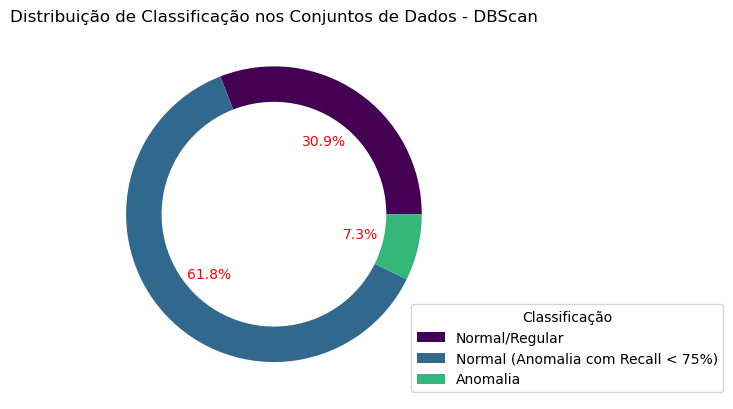

In [53]:
# Sua lista de dicionários
dados = dbscan_resultados

# Extrai os tipos de classificacao e suas contagens
tipos_classificacao = set(item['classificacao'] for item in dados)
contagens_classificacao = [sum(1 for item in dados if item['classificacao'] == tipo) for tipo in tipos_classificacao]

# Configurações do gráfico
fig, ax = plt.subplots()
ax.axis('equal')  # Mantém o gráfico de aspecto circular

# Cores para cada tipo de anomalia
cores = plt.cm.viridis(np.arange(len(tipos_classificacao)) / len(tipos_classificacao))

# Mapeia rótulos dos tipos de classificacao
rotulos_classificacao = {0: 'Normal/Regular', 1: 'Normal (Anomalia com Recall < 75%)', 2: 'Anomalia'}

# Cria o gráfico de rosca
wedges, texts, autotexts = ax.pie(contagens_classificacao, labels=None, autopct='%1.1f%%',
                                  textprops=dict(color="r"), colors=cores, wedgeprops=dict(width=0.24))

# Adiciona uma legenda customizada
ax.legend(wedges, [rotulos_classificacao[tipo] for tipo in tipos_classificacao], title="Classificação",
          loc="lower right", bbox_to_anchor=(1, 0, 0.42, 1))

plt.title("Distribuição de Classificação nos Conjuntos de Dados - DBScan")
plt.show()


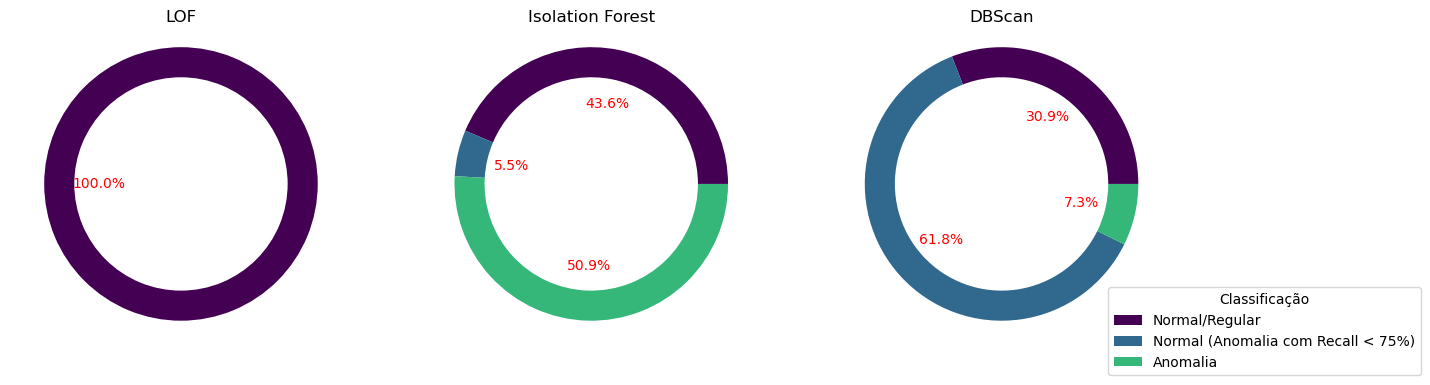

In [55]:
# Suas três listas de dicionários
dados_lista1 = lof_resultados
dados_lista2 = isolation_forest_resultados
dados_lista3 = dbscan_resultados

def plotar_grafico(ax, dados, titulo):
    tipos_classificacao = set(item['classificacao'] for item in dados)
    contagens_classificacao = [sum(1 for item in dados if item['classificacao'] == tipo) for tipo in tipos_classificacao]

    ax.axis('equal')  # Mantém o gráfico de aspecto circular

    # Cores para cada tipo de anomalia
    cores = plt.cm.viridis(np.arange(len(tipos_classificacao)) / len(tipos_classificacao))

    # Mapeia rótulos dos tipos de classificacao rotulos_classificacao = {0: 'Normal/Regular', 1: 'Normal (Anomalia com Recall < 75%)', 2: 'Anomalia'}

    # Cria o gráfico de rosca
    wedges, texts, autotexts = ax.pie(contagens_classificacao, labels=None, autopct='%1.1f%%',
                                      textprops=dict(color="r"), colors=cores, wedgeprops=dict(width=0.22))

    ax.set_title(titulo)

    return wedges, rotulos_classificacao.values()

# Configurações do gráfico geral
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 linha, 3 colunas

# Plota os gráficos para cada lista
wedges_lista1, rotulos_legenda = plotar_grafico(axs[0], dados_lista1, "LOF")
wedges_lista2, _ = plotar_grafico(axs[1], dados_lista2, "Isolation Forest")
wedges_lista3, _ = plotar_grafico(axs[2], dados_lista3, "DBScan")

# Adiciona uma única legenda para todos os gráficos
fig.legend(wedges_lista3, rotulos_legenda, title="Classificação", loc="lower right", bbox_to_anchor=(0.95, 0, 0.12, 1))

# plt.suptitle("Distribuição de Classificacao nos Conjuntos de Dados")
plt.show()


### Contagem de Votos para cada conjunto de Dados ###

In [56]:
print(lof_resultados, "\n")
print(isolation_forest_resultados, "\n")
print(dbscan_resultados, "\n")

[{'dataframe_id': 1, 'recall': 1.0, 'texto': 'Conjunto 1: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 2, 'recall': 1.0, 'texto': 'Conjunto 2: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 3, 'recall': 0.9655172413793104, 'texto': 'Conjunto 3: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 4, 'recall': 0.6896551724137931, 'texto': 'Conjunto 4: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 5, 'recall': 1.0, 'texto': 'Conjunto 5: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 6, 'recall': 1.0, 'texto': 'Conjunto 6: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 7, 'recall': 1.0, 'texto': 'Conjunto 7: Normal/Regular (Sem True Positives)', 'classificacao': 0, 'anomalia': 0}, {'dataframe_id': 8, 'recall': 1.0, 'texto': 'Conjunt

In [58]:
decisao_total_nft = []

# Inicializando um dicionário para armazenar a contagem de votos
votos = {}

# Iterar sobre cada registro nas listas
for lof, iso, dbs in zip(lof_resultados, isolation_forest_resultados, dbscan_resultados):
    dataframe_id = lof["dataframe_id"]
    votos[dataframe_id] = votos.get(dataframe_id, 0) + (lof["anomalia"] + iso["anomalia"] + dbs["anomalia"])

# Decidindo a anomalia com base na maioria dos votos
decisao_final = {}
for dataframe_id, total_votos in votos.items():
    decisao = 1 if total_votos >= 2 else 0
    decisao_final[dataframe_id] = decisao
    decisao_total_nft.append({dataframe_id: decisao})

# Imprimindo a decisão final
print(decisao_final)

# Se desejar imprimir as decisões individuais para cada dataframe_id:
# for decisao in decisao_total_nft:
#    print(decisao)


{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 1, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 1, 55: 0}


In [59]:
# Inicializando um dicionário para armazenar a contagem de votos
votos = {}

# Iterar sobre cada registro nas listas
for lof, iso, dbs in zip(lof_resultados, isolation_forest_resultados, dbscan_resultados):
    dataframe_id = lof["dataframe_id"]
    votos[dataframe_id] = votos.get(dataframe_id, 0) + (lof["anomalia"] + iso["anomalia"] + dbs["anomalia"])

# Decidindo a anomalia com base na maioria dos votos e armazenando em decisao_total_nft
decisao_total_nft = []
for dataframe_id, total_votos in votos.items():
    print(total_votos)
    decisao = 1 if total_votos >= 2 else 0
    decisao_total_nft.append({dataframe_id: decisao})

# Imprimindo a decisão final para cada registro
for decisao in decisao_total_nft:
    print(decisao)


1
1
1
0
0
0
1
0
1
0
1
0
0
1
1
1
0
1
0
0
1
0
1
2
0
1
1
1
0
0
0
0
1
1
1
2
1
1
1
0
1
1
0
0
0
0
0
0
1
0
1
0
0
2
1
{1: 0}
{2: 0}
{3: 0}
{4: 0}
{5: 0}
{6: 0}
{7: 0}
{8: 0}
{9: 0}
{10: 0}
{11: 0}
{12: 0}
{13: 0}
{14: 0}
{15: 0}
{16: 0}
{17: 0}
{18: 0}
{19: 0}
{20: 0}
{21: 0}
{22: 0}
{23: 0}
{24: 1}
{25: 0}
{26: 0}
{27: 0}
{28: 0}
{29: 0}
{30: 0}
{31: 0}
{32: 0}
{33: 0}
{34: 0}
{35: 0}
{36: 1}
{37: 0}
{38: 0}
{39: 0}
{40: 0}
{41: 0}
{42: 0}
{43: 0}
{44: 0}
{45: 0}
{46: 0}
{47: 0}
{48: 0}
{49: 0}
{50: 0}
{51: 0}
{52: 0}
{53: 0}
{54: 1}
{55: 0}


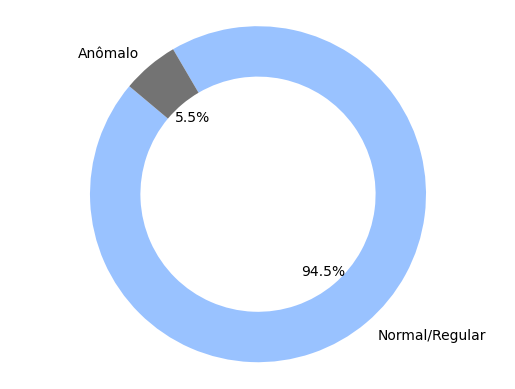

In [60]:
# Contar a frequência de valores normais (0) e anômalos (1)
contagem = {'Normal/Regular': 0, 'Anômalo': 0}
for decisao in decisao_total_nft:
    for _, valor in decisao.items():
        if valor == 0:
            contagem['Normal/Regular'] += 1
        else:
            contagem['Anômalo'] += 1

# Preparar os dados para o gráfico
labels = list(contagem.keys())
sizes = list(contagem.values())

# Cores para o gráfico
cores = ['#99c2ff', '#737373']

# Criar o gráfico do tipo rosca com as cores especificadas
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=cores, wedgeprops=dict(width=0.3))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



# Exibir o gráfico com as cores personalizadas
# plt.title("Distribuição de Decisões - Normal/Regular vs Anômalo")
plt.show()


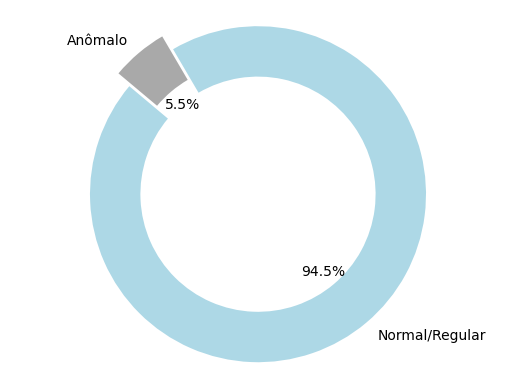

In [61]:
# Contar a frequência de valores normais (0) e anômalos (1)
contagem = {'Normal/Regular': 0, 'Anômalo': 0}
for decisao in decisao_total_nft:
    for _, valor in decisao.items():
        if valor == 0:
            contagem['Normal/Regular'] += 1
        else:
            contagem['Anômalo'] += 1

# Preparar os dados para o gráfico
labels = list(contagem.keys())
sizes = list(contagem.values())

# Cores para o gráfico
cores = ['#ADD8E6', '#A9A9A9']  # Azul claro e cinza

# Configuração de destaque para a fatia 'Normal/Regular'
explode = (0.1, 0)  # Destacar a fatia 'Normal/Regular'

# Criar o gráfico do tipo rosca com destaque
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=cores, wedgeprops=dict(width=0.3), explode=explode)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Exibir o gráfico com destaque
# plt.title("Distribuição de Decisões com Destaque - Normal/Regular vs Anômalo")
plt.show()


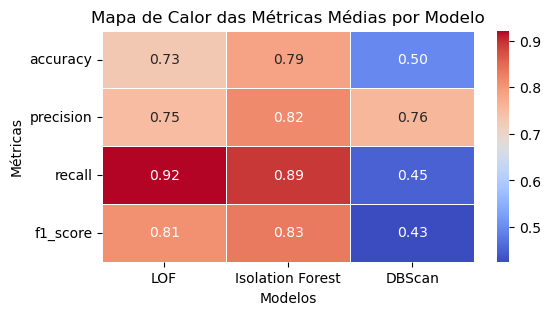

In [69]:
# Converter os dicionários para DataFrames
df_lof = pd.DataFrame.from_dict(lof_medias_final[0], orient='index', columns=['LOF'])
df_isolation_forest = pd.DataFrame.from_dict(isolation_forest_medias_final[0], orient='index', columns=['Isolation Forest'])
df_dbscan = pd.DataFrame.from_dict(dbscan_medias_final[0], orient='index', columns=['DBScan'])

# Concatenar os DataFrames ao longo das colunas
df = pd.concat([df_lof, df_isolation_forest, df_dbscan], axis=1)

# Criar o mapa de calor usando seaborn
plt.figure(figsize=(6, 3))
heatmap = sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Adicionar título e rótulos aos eixos
plt.title('Mapa de Calor das Métricas Médias por Modelo')
plt.xlabel('Modelos')
plt.ylabel('Métricas')

# Exibir o gráfico
plt.show()

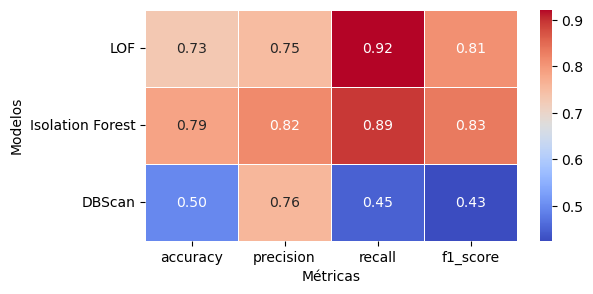

In [71]:
# Converter os dicionários para DataFrames
df_lof = pd.DataFrame.from_dict(lof_medias_final[0], orient='index', columns=['LOF'])
df_isolation_forest = pd.DataFrame.from_dict(isolation_forest_medias_final[0], orient='index', columns=['Isolation Forest'])
df_dbscan = pd.DataFrame.from_dict(dbscan_medias_final[0], orient='index', columns=['DBScan'])

# Concatenar os DataFrames ao longo das colunas
df = pd.concat([df_lof, df_isolation_forest, df_dbscan], axis=1)

# Criar o mapa de calor usando seaborn
plt.figure(figsize=(6, 3))
heatmap = sns.heatmap(df.T, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)  # Transpondo o DataFrame

# Adicionar título e rótulos aos eixos
# plt.title('Mapa de Calor das Métricas Médias por Modelo')
plt.xlabel('Métricas')
plt.ylabel('Modelos')
plt.show()